In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ete3 import Tree
import arviz as az

In [22]:
datapath = '../_root-experiment/simdata'  
folder_runs = '../_root-experiment/runs' 
treepath = '../data/chazot_subtree.nw'
folder_simdata = datapath 
burnin=10
MCMC_iter = 100
nxd = 40
nnodes = 9 
dataset = os.listdir(folder_runs)
dataset = [d for d in dataset if d not in ['figures', 'resubmit', '_convergence_diagnostics_all.pdf']]
dataset


['7680677238277473', '10953749833646560']

## Read in simulated data

In [23]:
all_pars = []
all_roots = []
all_vcv=[]
all_noisy_leaves = []
all_no_noise_leaves = []
for data in dataset: 
    # read parameters 
    sigma = np.genfromtxt(datapath+f'/{data}/gtheta_sim.csv', delimiter=',') 
    alpha = np.genfromtxt(datapath+f'/{data}/kalpha_sim.csv', delimiter=',') 
    true_pars = [alpha, sigma]
    all_pars.append(true_pars)

    # read root 
    root = np.genfromtxt(datapath+f'/{data}/root.csv', delimiter=',') 
    all_roots.append(root)
    vcv = np.genfromtxt(datapath+f'/{data}/phylogeny_vcv.csv', delimiter=' ')
    all_vcv.append(vcv)

    # read  leaves
    noisy_leaves = np.genfromtxt(datapath+f'/{data}/leaves.csv', delimiter=',') 
    all_noisy_leaves.append(noisy_leaves)
    no_noise_leaves = np.genfromtxt(datapath+f'/{data}/leaves_no_noise.csv', delimiter=',') 
    all_no_noise_leaves.append(no_noise_leaves)


In [24]:
def plot_leaves(leaves, root, true_pars, nrows=1, ncols=8, figsize=(25,5), leaves_no_noise=None): #figsize=(45,35)good for 30 leaves, nrows=6, ncols=5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=True, sharey=True)
    for i, ax in zip(range(leaves.shape[0]), axes.flat):
        ax.plot(leaves[i][::2], leaves[i][1::2], '--o', color='orange', label='leaf', lw=2)
        ax.plot(root[::2], root[1::2], '--.', color='black', label='true root')
        if leaves_no_noise.any(): 
            ax.plot(leaves_no_noise[i][::2], leaves_no_noise[i][1::2], '--o', color='steelblue', label='leaf', lw=1)
    fig.suptitle(f'Simulated data: alpha={np.round(true_pars[0],3)}, sigma={np.round(true_pars[1],3)}')
    return(ax)

In [25]:
def plot_leaves_superimposed(leaves, root, true_pars, nrows=2, ncols=4, figsize=(25,5)):
    for j in range(leaves.shape[0]): # plot all leaves on top of each other 
        plt.plot(leaves[j][::2], leaves[j][1::2], '--.', color='orange', label='leaf', lw=1)
    plt.plot(root[::2], root[1::2], '--.', color='black', label='true root', lw=4)
    plt.suptitle(f'Simulated data: alpha={np.round(true_pars[0],3)}, sigma={np.round(true_pars[1],3)}')
    plt.show()

In [26]:
len(dataset)

2

# Look at simulated data

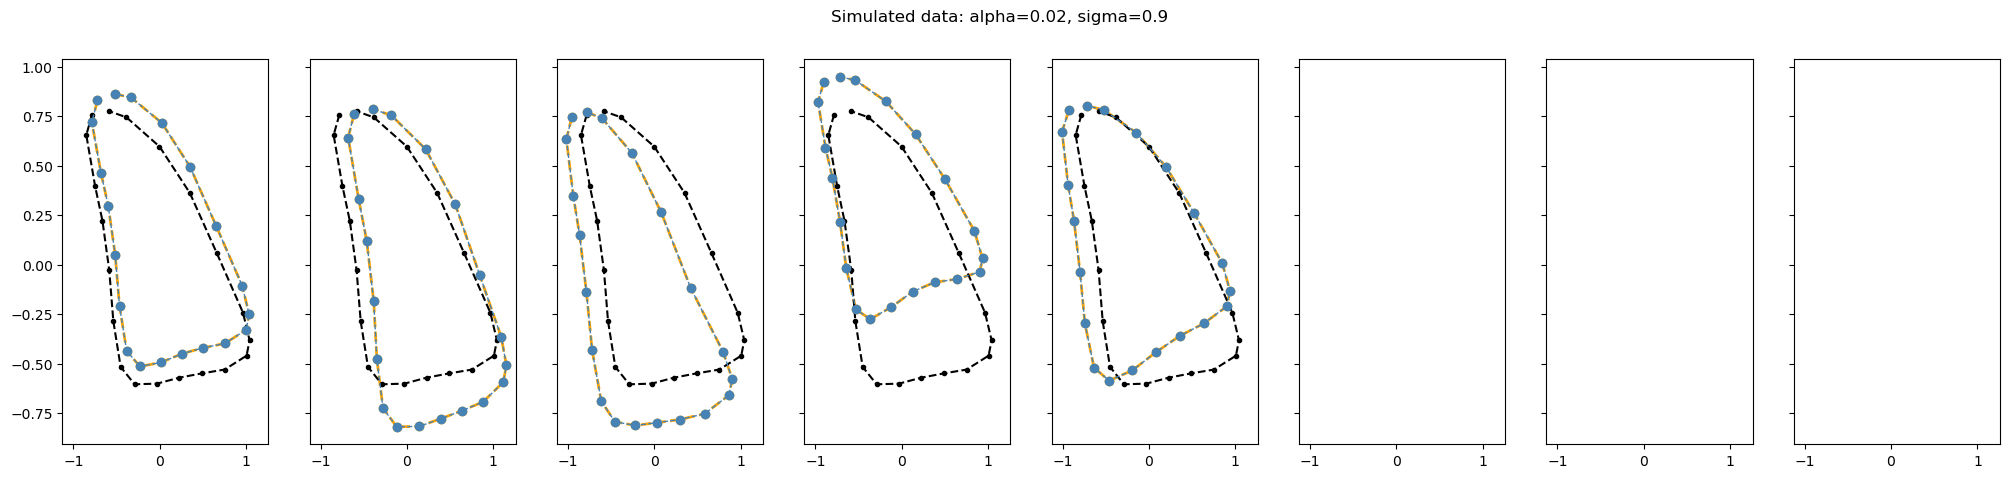

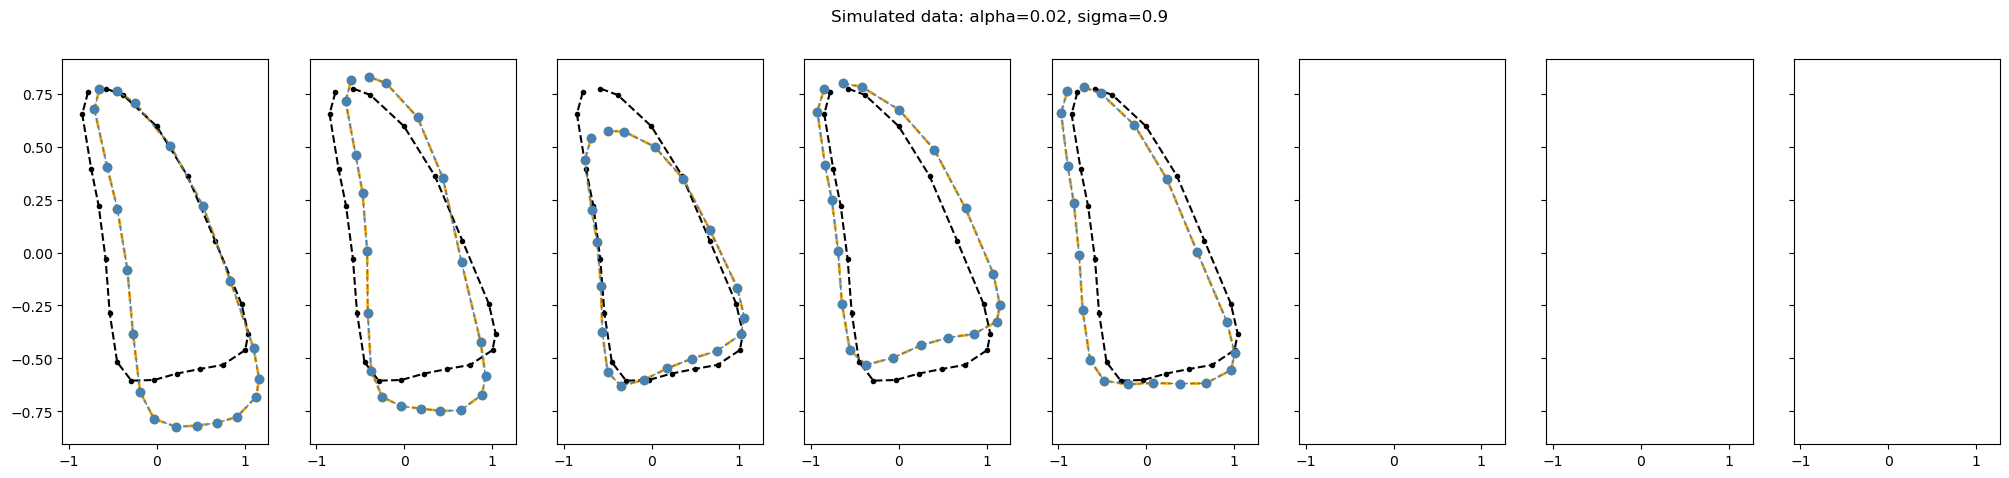

In [27]:
for i in range(len(dataset)):
    ax=plot_leaves(all_no_noise_leaves[i],all_roots[i], all_pars[i], leaves_no_noise=all_no_noise_leaves[i])


In [28]:
#for i in range(len(dataset)):
#    plot_leaves_superimposed(all_noisy_leaves[i],all_roots[i], all_pars[i])

# Compare different types of root estimates

### get mean and phylomean root estimates

In [29]:
def get_phylomean(leaves, vcv):
    phylomean = 1/(np.ones(leaves.shape[0]).T@np.linalg.inv(vcv)@np.ones(leaves.shape[0]))*np.ones(leaves.shape[0]).T@np.linalg.inv(vcv)@leaves
    return(phylomean)

In [10]:
# get mean and phylomean root estimates 
all_means = [np.mean(all_noisy_leaves[i], axis=0) for i in range(len(dataset))]
all_phylomeans = [get_phylomean(all_noisy_leaves[i], all_vcv[i]) for i in range(len(dataset))] # update this for more dynamic code


### Get posterior root estimates

In [11]:
def get_mode(all_chains): 
    mode_est = []
    for i in range(all_chains.shape[1]):
        kdes = az.kde(all_chains[:,i].flatten(), bw='silverman')
        mest = kdes[0][np.where(kdes[1] == max(kdes[1]))[0][0]]
        mode_est.append(mest)
    mode_est = np.array(mode_est)
    return(mode_est)

In [12]:
all_trees_flat = []
all_true_roots = []

for data in dataset: 
    cur_folder_runs = folder_runs + f'/{data}/'    
    nthin = 1 # see from script/running conditions, not used for plotting
    pars_name = ['kalpha', 'gtheta']
    rep_path = len(pars_name)+1
    chains = os.listdir(cur_folder_runs) # use all chains in data seed folder 
    chains = [c for c in chains if c[0] not in ['_', '.']] # remove files starting with underscore
    print(chains)


    # In[6]:
    outputfolder = cur_folder_runs
    temp_name = ['' for i in range(len(chains))]#['runs_'+chains[i]+'_' for i in range(len(chains))] #[outputfolder+chains[i]+'/' for i in range(len(chains))] # #['runs_'+chains[i]+'_' for i in range(len(chains))] #['runs_'+chains[i]+'_' for i in range(len(chains))] #
    path = outputfolder+'_*'+'-'.join(chains)
    if not os.path.isdir(path): 
        os.mkdir(path)

    #tree = Tree(treepath)
    #leafidx = []
    #inneridx = []
    #i = 0
    #for node in tree.traverse('levelorder'):
    #    if node.is_leaf():
    #        print(node.name)
    #        leafidx.append(i)
    #    else:
    #        inneridx.append(i)
    #    i+=1
    #print(leafidx)
    #print(inneridx)

    # # Plot paths all nodes 
    raw_trees = [np.genfromtxt(cur_folder_runs + chains[i]+'/'+temp_name[i]+"tree_nodes.csv", delimiter = ",") for i in range(len(chains))]
    tree_counters = [np.genfromtxt(cur_folder_runs + chains[i]+'/'+temp_name[i]+"tree_counter.csv", delimiter = ",").astype(int) for i in range(len(chains))]
    flat_trees_raw = [raw_trees[i].reshape(len(tree_counters[i]),nnodes,nxd) for i in range(len(raw_trees))]
    flat_true_tree = np.genfromtxt(folder_simdata+f"/{data}/flat_true_tree.csv", delimiter = ",")
    ## The code below is necessary if different MCMC iter has been used to achieve convergence 
    #if data in ['25820275382873925', '66116740010474124']: 
    #        print(f'resub + {data}')
    #        flat_trees = np.array([np.repeat(flat_trees_raw[i], tree_counters[i], axis=0)[2000*rep_path:(6000//nthin)*rep_path] for i in range(len(flat_trees_raw))])
    #if data in ['55491231187012442']:
    #        print(f'resub + {data}')
    #        flat_trees = np.array([np.repeat(flat_trees_raw[i], tree_counters[i], axis=0)[2000*rep_path:(10000//nthin)*rep_path] for i in range(len(flat_trees_raw))])
    #else:
    flat_trees = np.array([np.repeat(flat_trees_raw[i], tree_counters[i], axis=0)[burnin*rep_path:(MCMC_iter//nthin)*rep_path] for i in range(len(flat_trees_raw))])
    all_trees_flat.append(flat_trees)
    all_true_roots.append(flat_true_tree[0])

['proud-silence-98', 'colorful-fire-97', 'decent-lion-98']
['sunny-sea-102', 'charmed-durian-100', 'dry-aardvark-100']


In [13]:
# get posterior mean and posterior median 
all_proots = [all_trees_flat[i][:,:,0,:].reshape(-1,40) for i in range(len(all_trees_flat))] # get all roots, across chains for all data sets 
all_median_root = [np.median(all_proots[i], axis=0) for i in range(len(all_proots))]
all_mean_root = [np.mean(all_proots[i], axis=0) for i in range(len(all_proots))]
all_mode_root = [get_mode(all_proots[i]) for i in range(len(all_proots))]

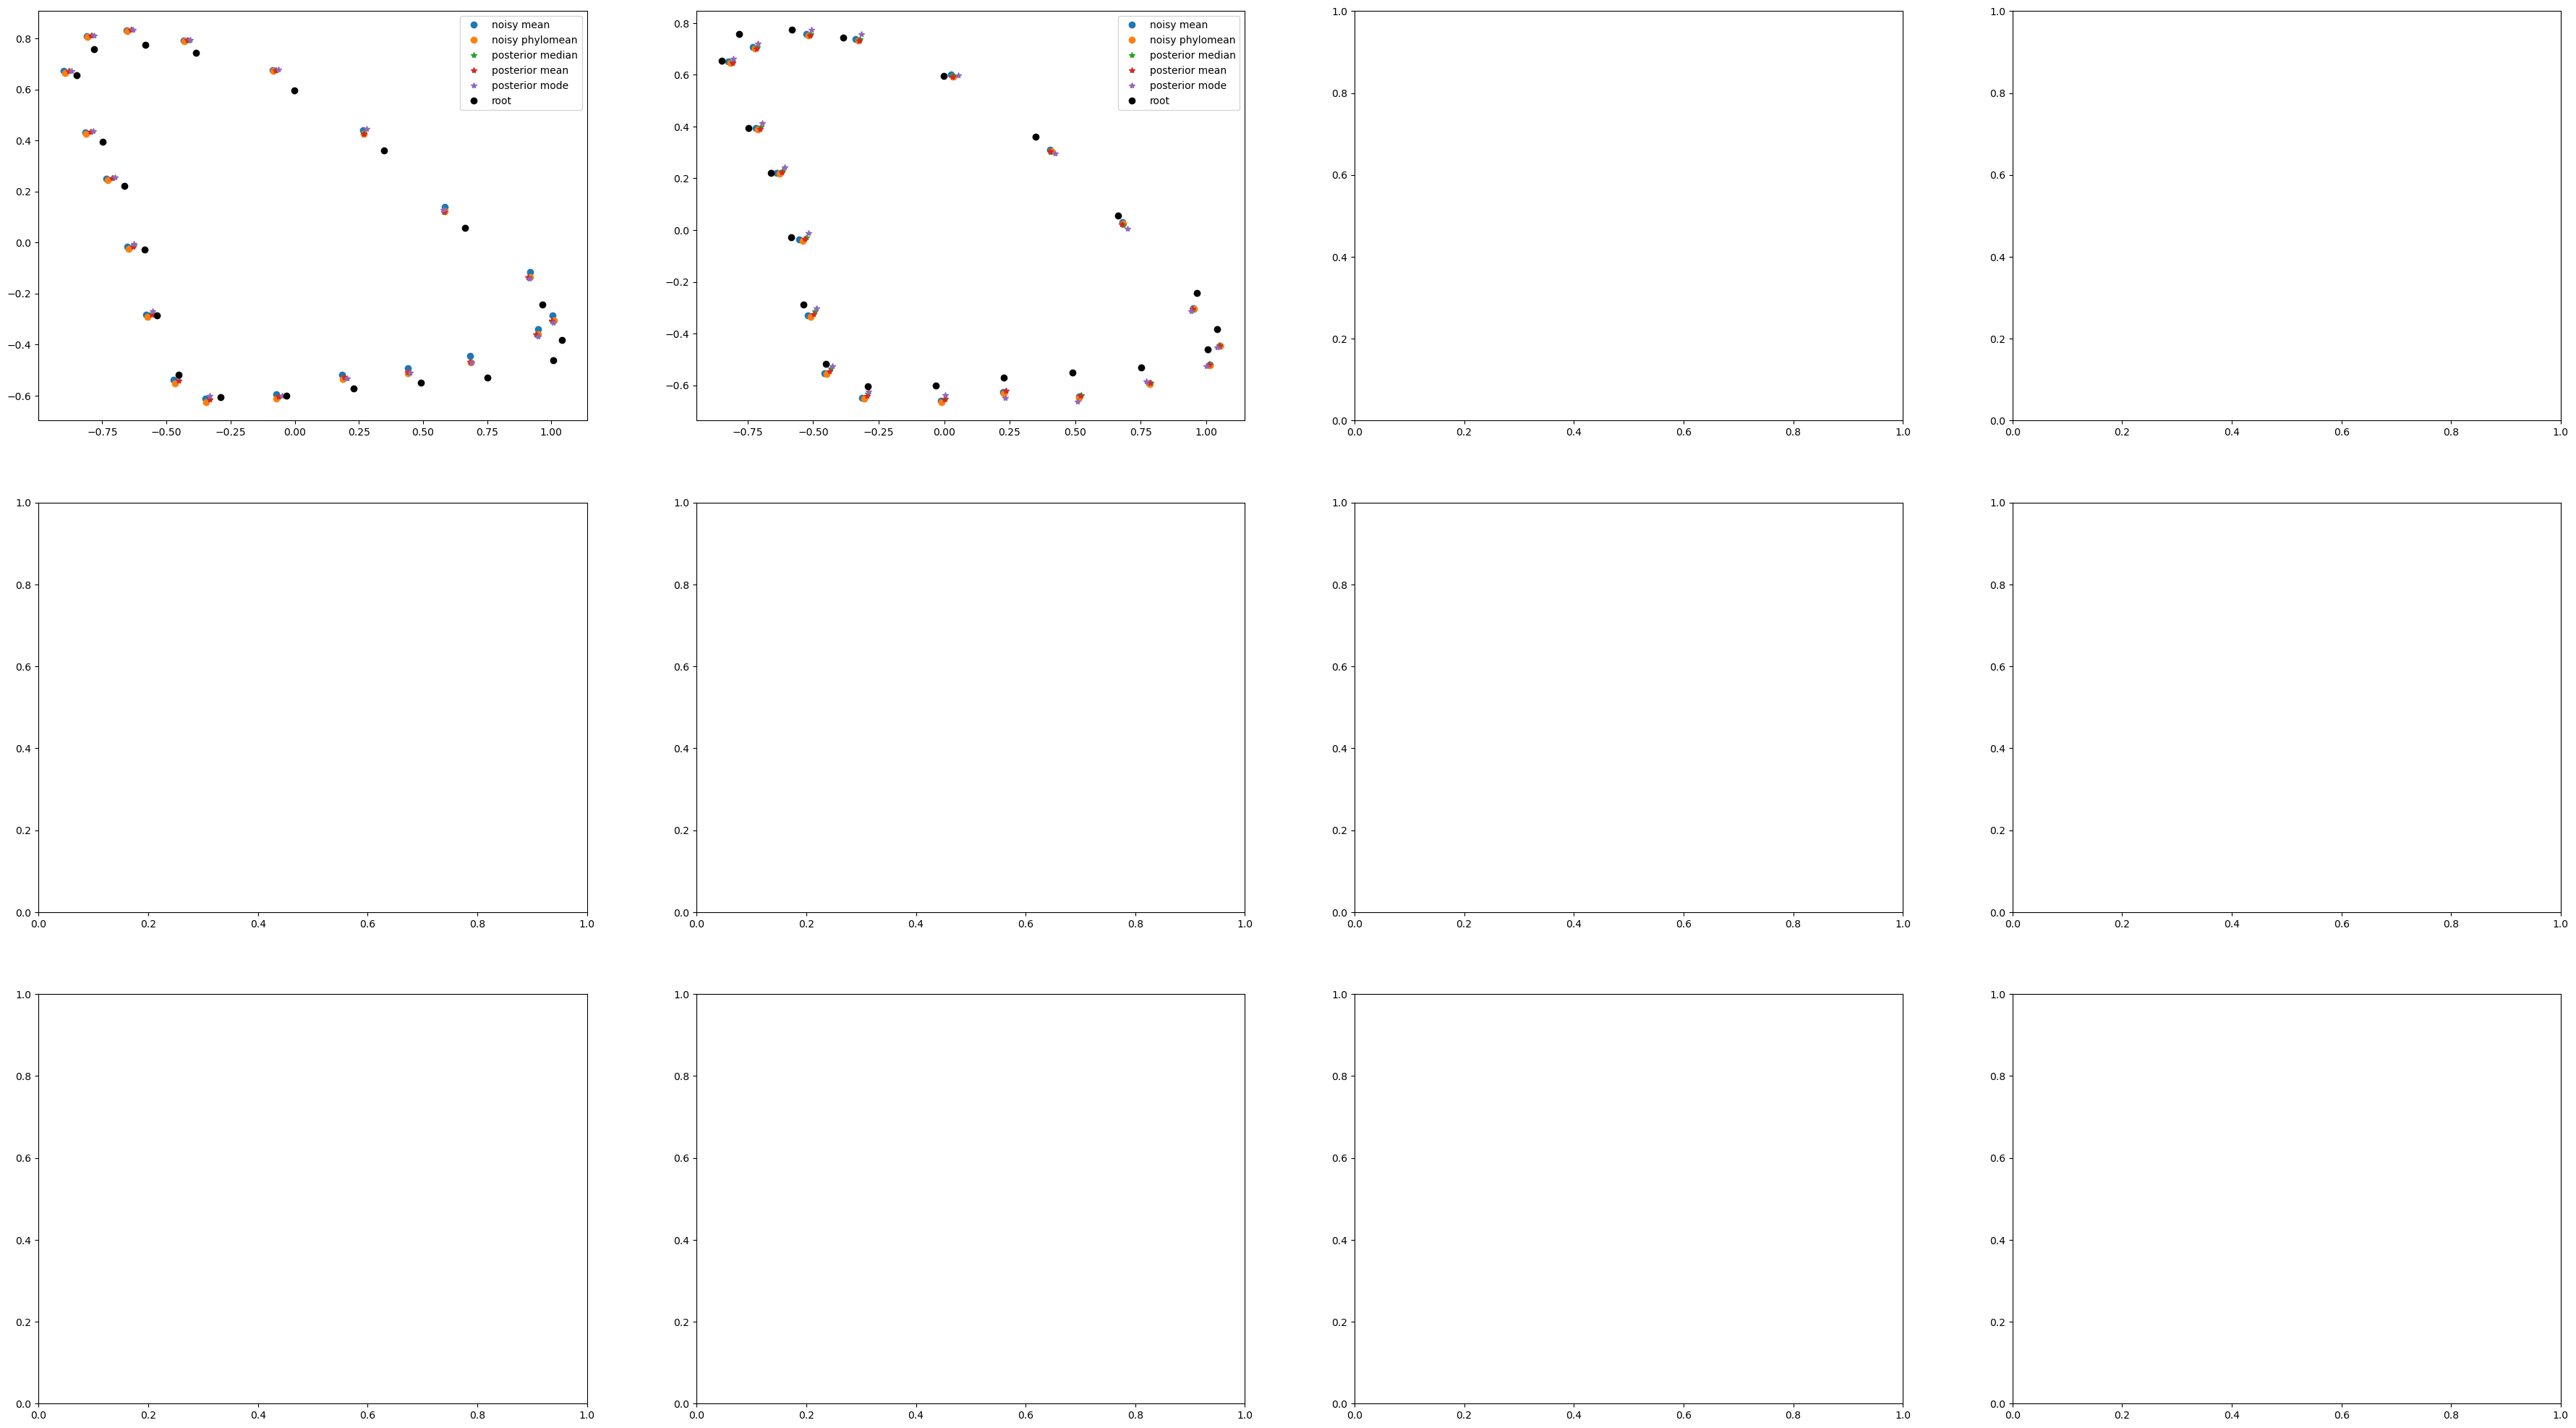

In [14]:
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(45,25))
for i, ax in zip(range(len(dataset)), axes.flat):
    ax.plot(all_means[i][0::2],all_means[i][1::2], 'o', label='noisy mean')
    ax.plot(all_phylomeans[i][0::2],all_phylomeans[i][1::2], 'o', label='noisy phylomean')
    ax.plot(all_median_root[i][::2], all_median_root[i][1::2], '*', label='posterior median')
    ax.plot(all_mean_root[i][::2], all_mean_root[i][1::2], '*', label='posterior mean')
    ax.plot(all_mode_root[i][::2], all_mode_root[i][1::2], '*', label='posterior mode')
    ax.plot(all_true_roots[i][::2], all_true_roots[i][1::2], 'o', label='root', color='black')
    ax.legend()

# MSE for different root estimates

In [15]:
MSE_mean = []
MSE_phylomean = []
MSE_posterior_mean = []
MSE_posterior_mode = []
MSE_posterior_median = []
for i in range(len(dataset)):
    MSE_mean.append(np.mean((all_means[i]-all_true_roots[i])**2))
    MSE_phylomean.append(np.mean((all_phylomeans[i]-all_true_roots[i])**2))
    MSE_posterior_mean.append(np.mean((all_mean_root[i]-all_true_roots[i])**2))
    MSE_posterior_median.append(np.mean((all_median_root[i]-all_true_roots[i])**2))
    MSE_posterior_mode.append(np.mean((all_mode_root[i]-all_true_roots[i])**2))


In [16]:
print(dataset)
print(MSE_mean)
print(MSE_phylomean)
print(MSE_posterior_mean)
print(MSE_posterior_median)
print(MSE_posterior_mode)

['7680677238277473', '10953749833646560']
[np.float64(0.003846721098221537), np.float64(0.0014730946045774444)]
[np.float64(0.003037545801223738), np.float64(0.0018432466766678181)]
[np.float64(0.0028620580984850545), np.float64(0.0017815267285897704)]
[np.float64(0.002714843620561673), np.float64(0.0017841064478918984)]
[np.float64(0.002545050478382005), np.float64(0.0022468776685803512)]


In [17]:
all_MSE = np.array([MSE_mean, MSE_phylomean, MSE_posterior_mean, MSE_posterior_median, MSE_posterior_mode])
np.mean(all_MSE, axis=1)

array([0.00265991, 0.0024404 , 0.00232179, 0.00224948, 0.00239596])

In [18]:
#plt.boxplot(all_MSE.T)